# Задание 5.1

Вычислить интеграл с помощью квадратурных формул левых прямоугольников,
Гаусса и по формуле Милна


$$I = \int_{1}^{3} P_m(x) \,dx$$
$$P_m(x) = \sum_{i=0}^{n} c_i x^i $$
$$c = [0,	–2.9,	–0.9,	0.4,	1.9,	–4.2]$$\
аналитическое вычисление интеграла
$$\int_{1}^{3} P_m(x) \,dx  = \int_{1}^{3} (-2.9 x - 0.9 x^2 + 0.4 x^3 + 1.9 x^4 - 4.2 x^5) \,dx = 
(-\frac{2.9}{2} x^2 - \frac{0.9}{3} x^3 + \frac{0.4}{4} x^4 + \frac{1.9}{5} x^5 - \frac{4.2}{6} x^6)|^3_1 = -429.04$$

In [ ]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass, field
from typing import Callable, ClassVar, Dict, Optional
from scipy import integrate

In [ ]:
def f(x):
    return -2.9 * x - 0.9 * x ** 2 + 0.4 * x ** 3 + 1.9 * x ** 4 - 4.2 * x ** 5

In [ ]:
# аналитическое решение
def int_f(a, b, c=np.array([0, -2.9, -0.9, 0.4, 1.9, -4.2])):
    return np.sum([c[i] * (b ** (i + 1) - a ** (i + 1)) / (i + 1) for i in range(len(c))])


def error(i, exact_i):
    return np.abs(exact_i - i)

In [ ]:
# класс Timer для определения метода с наименьшим временем вычисления

class TimerError(Exception):
    pass


@dataclass
class Timer:
    timers: ClassVar[Dict[str, float]] = dict()
    name: Optional[str] = None
    text: str = "Elapsed time: {:0.4f} seconds"
    logger: Optional[Callable[[str], None]] = print
    _start_time: Optional[float] = field(default=None, init=False, repr=False)

    def __post_init__(self):
        if self.name:
            self.timers.setdefault(self.name, 0)

    def start(self):
        if self._start_time is not None:
            raise TimerError("Timer is running. Use .stop() to stop it.")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError("Timer is not running. Use .start() to start it.")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None

        if self.logger:
            self.logger(self.text.format(elapsed_time))

        if self.name:
            self.timers[self.name] += elapsed_time

        return elapsed_time

Формула левых прямоугольников: $$S = h \sum_{i=0}^{n - 1} f(x_i)$$
Остаточный член: $$R = \frac{M_1(b-a)}{2}h$$

In [ ]:
class RectLeftError(Exception):
    pass


class RectLeft:

    def __init__(self, left, right, h, eps, func=f):
        self.left = left
        self.right = right
        self.__h = h
        self.eps = eps
        self.func = func
        self.__i = None
        self.__n = int((right - left) / h) + 1
        self.__h = (right - left) / (self.__n - 1)

    def h_eval(self):
        x = Symbol('x')
        # для вычисления дифференциала заданного порядка
        lam_m = lambdify(x, diff(self.func(x), x))
        x_data = np.linspace(self.left, self.right, 500)
        max_m = np.max(np.abs(lam_m(x_data)))
        try:
            self.__h = 2 * self.eps / (max_m * (self.right - self.left))
        except ZeroDivisionError:
            self.__h = self.right - self.left

        self.__n = int((self.right - self.left) / self.__h) + 1
        self.__h = (self.right - self.left) / (self.__n - 1)

    def eval(self):
        self.__i = self.__h * np.sum([self.func(self.left+i*self.__h) for i in range(self.__n - 1)])

    def get_h(self):
        return self.__h

    def get_i(self):
        if self.__i:
            return self.__i
        else:
            raise RectLeftError("The integral is not evaluated. Use .eval()")

    def get_n(self):
        return self.__n

    def show_attr(self):
        print(f"Rect: integral = {self.__i}, h = {self.__h}, n = {self.__n}")

Формула Милна: $$S = \frac{h}{90} \sum_{i=1}^{n} [7f(x_{i-1}) + 32f(x_{i-1} + \frac{h}{4}) + 12f(x_{i-0.5}) + 32f(x_i - \frac{h}{4}) + 7f(x_i) ]$$
Остаточный член: $$R = \frac{M_6(b-a)}{1935360}h^6$$
Правило Рунге: $$R^{\frac{h}{2}} = \frac{I^{\frac{h}{2}} - I^h}{2^p - 1}$$

In [ ]:
class NewtonCotesError(Exception):
    pass


class NewtonCotes:
    """Методы Ньютона-Котеса являются интерполяционными квадратурными формулами"""

    def __init__(self, left, right, h, eps, m=4, func=f):
        if m not in (1, 2, 3, 4, 5, 6):
            raise NewtonCotesError("degree of polynomial - m is not in (1, 2, 3, 4, 5, 6)")
        self.left = left
        self.right = right
        self.__h = h
        self.eps = eps
        self.m = m
        self.func = func
        self.__i = None
        self.__n = int((right - left) / h) + 1
        self.__h = (right - left) / (self.__n - 1)

        self.elem_int = {
            1: lambda i, x: self.__h / 2 * (self.func(x[i - 1]) + self.func(x[i])),
            2: lambda i   : self.__h / 6 * (self.func(self.left + (i-1)*self.__h) + 4 * self.func(self.left + i*self.__h - self.__h / 2) + self.func(self.left + i*self.__h)),
            4: lambda i   : self.__h / 90 * (7 * self.func(self.left + (i-1)*self.__h) + 32 * self.func(self.left + (i-1)*self.__h + self.__h / 4) +
                                             12 * self.func(self.left + i*self.__h - self.__h / 2) + 32 * self.func(self.left + i*self.__h - self.__h / 4) +
                                             7 * self.func(self.left + i*self.__h))
        }

        self.formula_name = {
            1: "Trapezoid",
            2: "Simpson",
            3: "3/8",
            4: "Milne",
            5: "fifth_degree",
            6: "Waddle"
        }

        self.error_coeff = {
            1: 1 / 12,
            2: 1 / 2880,
            3: 1 / 6480,
            4: 1 / 1935360,
            5: 1 / 37800000,
            6: 1 / 1567561600
        }

        self.degree = {
            1: 2,
            2: 4,
            3: 4,
            4: 6,
            5: 6,
            6: 8
        }

    def h_eval(self):
        x = Symbol('x')
        lam_m = lambdify(x, diff(self.func(x), x, self.degree[self.m]))
        x_data = np.linspace(self.left, self.right, 500)
        max_m = np.max(np.abs(lam_m(x_data)))
        if max_m != 0:
            self.__h = np.power(self.eps / (self.error_coeff[self.m] * max_m * (self.right - self.left)),
                                1 / self.degree[self.m])
        else:
            self.__h = self.right - self.left

        self.__n = int((self.right - self.left) / self.__h) + 1
        self.__h = (self.right - self.left) / (self.__n - 1)


    def get_h(self):
        return self.__h

    def get_i(self):
        if self.__i:
            return self.__i
        else:
            raise NewtonCotesError("The integral is not evaluated. Use .eval()")

    def get_n(self):
        return self.__n

    def eval(self):
        self.__i = np.sum([self.elem_int[self.m](i) for i in range(1, self.__n)])

    def Runge(self):
        self.eval()
        integral = self.__i
        while True:
            self.__n *= 2
            self.__h = (self.right - self.left) / (self.__n - 1)
            self.eval()
            integral_half = self.__i
            if np.abs(integral - integral_half) / (2 ** self.degree[self.m] - 1) <= self.eps:
                break
            integral = integral_half
        self.__i = integral_half



    def show_attr(self):
        print(f"{self.formula_name[self.m]}: integral = {self.__i}, h = {self.__h}, n = {self.__n}")

NameError: ignored

Квдратурная формула Гаусса: $$\int_{a}^{b} f(x) \,dx \approx \frac{b-a}{2}\sum_{i=0}^{N} a_i f[\frac{a+b}{2} + \frac{b-a}{2}t_i]$$
Точна для многочленов степени m = 2N + 1. N + 1 - число узлов квадратуры. Данная подынтегральный полином имеет степень m = 5. Следовательнос, берем число узлов N + 1 = 3

In [ ]:
class GaussError(Exception):
    pass


class Gauss:
    def __init__(self, left, right, n, func=f):
        if n not in (1, 2, 3, 4, 5, 6):
            raise GaussError("count of root - N is not in (1, 2, 3, 4, 5, 6)")
        self.left = left
        self.right = right
        self.n = n
        self.func = func
        self.__i = None

        self.root_weight = {
            # узлы и веса квадратурной формулы Гаусса
            # с числом узлов от 1 до 5
            # количество узлов : [t, a]
            1: np.array([[0.0],
                         [2.0]]),
            2: np.array([[-0.5773502691896258, 0.5773502691896258],
                         [1.0, 1.0]]),
            3: np.array([[-0.7745966692414834, 0.0, 0.7745966692414834],
                         [0.5555555555555556, 0.8888888888888888, 0.5555555555555556]]),
            4: np.array([[-0.8611363115940526, -0.3399810435848562, 0.3399810435848562, 0.8611363115940526],
                         [0.34785484513745385, 0.6521451548625461, 0.6521451548625461, 0.34785484513745385]]),
            5: np.array([[-0.9061798459386641, -0.5384693101056831, 0.0, 0.5384693101056831, 0.9061798459386641],
                         [0.23692688505618906, 0.4786286704993664, 0.5688888888888889, 0.4786286704993664, 0.23692688505618906]]),
        }

    def eval(self):
        self.__i = (self.right - self.left) / 2 * \
                   np.sum([self.root_weight[self.n][1][i] *
                           self.func((self.right + self.left) / 2 +
                                     (self.left - self.right) / 2 * self.root_weight[self.n][0][i])
                           for i in range(self.n)])

    def get_i(self):
        if self.__i:
            return self.__i
        else:
            raise GaussError("The integral is not evaluated. Use .eval()")

    def show_attr(self):
        print(f"Gauss: integral = {self.__i}, N = {self.n}")


In [ ]:
a = 1.
b = 3.
eps = 1e-2
h = 0.5
N = 3

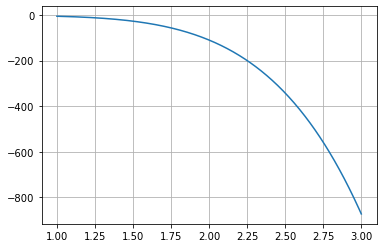

In [ ]:
fig, axs = plt.subplots()
x_data = np.linspace(a, b, 500)
axs.plot(x_data, f(x_data))
axs.grid()

In [ ]:
# метод левых прямоугольников
t = Timer("RectLeft", logger=None)
rect = RectLeft(a, b, h, eps)
t.start()
rect.h_eval()
rect.eval()
t.stop()

# метод Ньютона-Котеса
t = Timer("NC", logger=None)
nc = NewtonCotes(a, b, h, eps, m=4)
t.start()
nc.h_eval()
nc.eval()
t.stop()


# метод Гаусса
t = Timer("Gauss", logger=None)
gauss = Gauss(a, b, N)
t.start()
gauss.eval()
t.stop()

0.00012400000014167745

In [ ]:
# аналитическое решение интеграла и погрешности
# integral = int_f(a, b)
integral = -429.04
rect_err, nc_err, gauss_err = map(lambda i: error(i, integral), 
                                  [rect.get_i(), nc.get_i(), gauss.get_i()])

print("Точное значение: ", integral)
rect.show_attr()
nc.show_attr()
gauss.show_attr()
print(f"{rect_err = }, {nc_err = }, {gauss_err = }")

print(Timer.timers)
Timer.timers.clear()

Точное значение:  -429.04
Rect: integral = -429.03709703893315, h = 6.696578048617156e-06, n = 298661
Milne: integral = -429.04, h = 2.0, n = 2
Gauss: integral = -429.04, N = 3
rect_err = 0.002902961066865828, nc_err = 0.0, gauss_err = 0.0
{'RectLeft': 0.36026849999961996, 'NC': 0.001481700000113051, 'Gauss': 0.00012400000014167745}




|Точное значение |-429.04 |            |            |        |
|----------------|----------|-------------|------------||
|Метод левых прямоугольников |-429.037 | h = 6.67e-06 | n = 298661 |err = 0.003 |
Метод Милна|429.04  |  h = 2.0  | n = 2| err = 0.0 |
Метод Гаусса| -429.04|     |  N = 3|err = 0.0  |



# Задание 5.2
$$f(x) = 4 sin(2^x)$$
$$[a, b] = [-4, 0]$$
$$eps = 10^{-12}$$

In [ ]:
a, b, eps = -4, 0, 1e-12
h = 0.5

def ff(x):
    return 4 * np.sin(2**x)

Уточнение по Рунге: $$I \approx I^{\frac{h}{2}} + \frac{I^{\frac{h}{2}} - I^h}{2^p - 1},$$ где p - порядок точности формулы

In [ ]:
def Runge_refinement(nc):
    nc_double = NewtonCotes(-4, 0, 2 * nc.get_h(), 1e-12, func=ff)
    nc_double.eval()
    return nc.get_i() + (nc.get_i() - nc_double.get_i()) / (2 ** 6 - 1), nc_double.get_i()

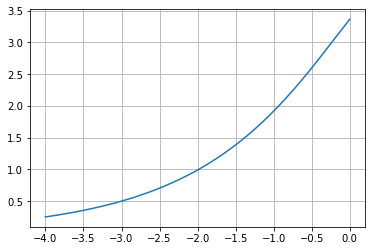

In [ ]:
fig, axs = plt.subplots()
x_data = np.linspace(a, b, 500)
axs.plot(x_data, ff(x_data))
axs.grid()

In [ ]:
# точное значение интеграла
t = Timer("Gauss", logger=None)
t.start()
integral, err = integrate.quadrature(ff, a, b, tol=1e-14, rtol=1e-14)
t.stop()
print(f"{integral = }")
print(f"{err = }")

integral = 5.099041917372243
err = 1.2434497875801753e-14


In [ ]:
m = NewtonCotes(a, b, h, eps, m=4, func=ff)
t = Timer("Milne", logger=None)
t.start()
m.Runge()
t.stop()
m.show_attr()

m_runge, m_h2 = Runge_refinement(m)
print(f"I_h2:  integral = {m_h2}")
print(f"Runge: integral = {m_runge}")

print("С удвоенным шагом   ", np.abs(integral - m_h2))
print("С заданной точностью", np.abs(integral - m.get_i()))
print("Уточнение по Рунге  ", np.abs(integral - m_runge))

print("Timer: ", Timer.timers)
Timer.timers.clear()

Milne: integral = 5.099041917372067, h = 0.056338028169014086, n = 72
I_h2:  integral = 5.099041917359926
Runge: integral = 5.09904191737226
С удвоенным шагом    1.2316370145981637e-11
С заданной точностью 1.758593271006248e-13
Уточнение по Рунге   1.687538997430238e-14
Timer:  {'Gauss': 0.0004073000000062166, 'Milne': 0.00192109999989043}


||значение интеграла|шаг|количество узлов|погрешность|
|-|-----------------|----------|-------|----------------------------|
|I|5.099041917372243| | |err=1.24e-14|
|$I^h$|5.099041917372067|h = 0.056 | n = 72| err = 1.76e-13|
|$I^{2h}$|5.099041917359926| h = 0.112| n = 144|err = 1.23e-11|
|Уточнение по Рунге|5.09904191737226| | |err = 1.69e-14|


